#### Contest entry by Wouter Kimman 


Strategy: 
----------------------------------------------



In [1]:
from numpy.fft import rfft
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py


import pandas as pd
import timeit
from sqlalchemy.sql import text
from sklearn import tree
from sklearn.model_selection import LeavePGroupsOut

#from sklearn import cross_validation
#from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
#import sherlock.filesystem as sfs
#import sherlock.database as sdb

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

In [3]:
filename = 'training_data.csv'
training_data0 = pd.read_csv(filename)
training_data1=training_data0.copy()

In [4]:

def magic(df):
    df1=df.copy()
    b, a = signal.butter(2, 0.2, btype='high', analog=False)
    feats00=['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
    feats01=['GR','DeltaPHI','PHIND']
    for ii in feats01:
        df1[ii]=df[ii]
        name1=ii + '_1'
        name2=ii + '_2'
        name3=ii + '_3'
        name4=ii + '_4'
        xx1 = list(df[ii])
        xx_mf= signal.medfilt(xx1,9)
        x_min3=np.roll(xx_mf, 3)    
        xx1a=xx1-np.mean(xx1)
        xx_fil = signal.filtfilt(b, a, xx1)
        xx_grad=np.gradient(xx1a) 
        if ii in feats01: 
            df1[name1]=x_min3
            df1[name2]=xx_fil
            df1[name3]=xx_grad
            df1[name4]=xx_mf     
    return df1

        


        
        

In [5]:
def run_test(remove_well, df_train):
    
    df_test=training_data1
    blind = df_test[df_test['Well Name'] == remove_well]      
    training_data = df_train[df_train['Well Name'] != remove_well]  
    
    correct_facies_labels_train = training_data['Facies'].values
    feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    #rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf = RandomForestClassifier(max_depth = 5, n_estimators=600)     
    rf.fit(feature_vectors, correct_facies_labels_train)

    correct_facies_labels = blind['Facies'].values
    features_blind = blind.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    scaler = preprocessing.StandardScaler().fit(feature_vectors)
    scaled_features =feature_vectors
    predicted_random_forest = rf.predict(features_blind)

    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    return out_f1

    
    

In [6]:
def dothererun(selected_pred_facies):
    training_data_dodgy = blind[selected_data==True]  

    # PART BLIND WELL TO TRAIN
    #correct_facies_labels_train = training_data_dodgy['Facies'].values  #THIS WOULD OBVIOUSLY NOT BE AVAILABLE
    correct_facies_labels_train = selected_pred_facies
    feature_vectors = training_data_dodgy.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    #rf = RandomForestClassifier(max_depth = 25, n_estimators=5000) 
    rf = RandomForestClassifier(max_depth = 5, n_estimators=1000)     
    rf.fit(feature_vectors, correct_facies_labels_train)

    # ENTIRE BLIND WELL TO PREDICT
    correct_facies_labels = blind['Facies'].values
    features_blind = blind.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
    
    predicted_random_forest_new = rf.predict(features_blind)
    
    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest_new,average = 'micro')
    props=rf.predict_proba(features_blind)
    print "in the rerun f1 is: "
    print out_f1
    return out_f1


In [7]:
df=training_data0.copy()
training_data1=magic(df)

In [6]:
df_train=training_data1

wells=['CHURCHMAN BIBLE','SHANKLE','NOLAN','NEWBY','Recruit F9' ,'CROSS H CATTLE','LUKE G U','SHRIMPLIN']
#wells=['CHURCHMAN BIBLE']
wells=['NOLAN']
for remove_well in wells:
    all=[]
    print("well : %s, f1 for different runs:" % (remove_well))
    for ii in range(4):
        out_f1=run_test(remove_well,df_train)   
        #out_f1=run_bayes2(remove_well,df_train) 
        all.append(out_f1)
    av1=np.mean(all) 
    print("average f1 is %f, 2*std is %f" % (av1, 2*np.std(all)) )


well : NOLAN, f1 for different runs:
average f1 is 0.525904, 2*std is 0.010434


In [337]:
df_test=training_data1
blind = df_test[df_test['Well Name'] == remove_well]      
training_data = df_train[df_train['Well Name'] != remove_well]  
    
correct_facies_labels_train = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
rf = RandomForestClassifier(max_depth = 5, n_estimators=1000) 
rf.fit(feature_vectors, correct_facies_labels_train)

correct_facies_labels = blind['Facies'].values
features_blind = blind.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
#scaler = preprocessing.StandardScaler().fit(feature_vectors)
#scaled_features =feature_vectors
predicted_random_forest = rf.predict(features_blind)

out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
print out_f1

props=rf.predict_proba(features_blind)
props_best=props.max(axis=1)

0.532530120482


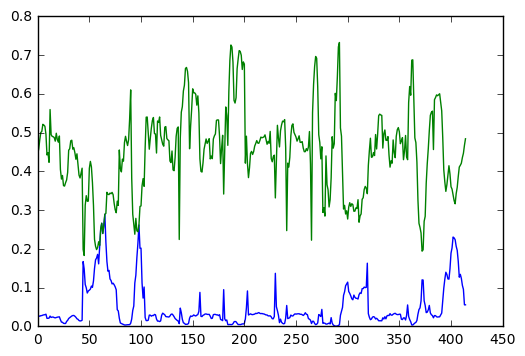

0.449710576641
0.559843757226


In [342]:
plt.plot(props[:,3])
plt.plot(props_best)
plt.show()
print props_best.mean()
print props_best.mean()+props_best.std()

RERUNNING PREDICTION FROM PART BLIND ONLY:

In [343]:
#decs=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
#decs=[0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42]
decs=[0.20, 0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44]
#decs=[0.32, 0.325, 0.33, 0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.38, 0.4, 0.42, 0.44]
decs=[0.15]
decs=[0.625]
for vals in decs:
    new_array=[]
    selected_data=[]
    selected_data=0*predicted_random_forest
    count=0
    for idx, val in enumerate(props_best):
        if val > vals:
            new_array.append(predicted_random_forest[idx])
            selected_data[idx]=True
            count+=1
        else:
            selected_data[idx]=False
            

    selected_pred_facies=predicted_random_forest[selected_data==True]
    selected_true_labels=correct_facies_labels[selected_data==True]    
    out_f1=metrics.f1_score(selected_true_labels, selected_pred_facies,average = 'micro')
    
    print("vals of decs is  %.5f " %  (vals) ) 
    print("nr of samples %d " %  (count) )     
    print("total nr of facies predicted is %d" % (len(np.unique(selected_pred_facies))))
    print("total nr of facies present is %d" % (len(np.unique(selected_true_labels))))    
    print("f1 is  %.5f " %  (out_f1) ) 
    #dothererun(selected_pred_facies)   
    print "-------------------------------------------------"

vals of decs is  0.62500 
nr of samples 24 
total nr of facies predicted is 2
total nr of facies present is 2
f1 is  0.66667 
-------------------------------------------------


Leave 2 out

In [314]:

wells = training_data["Well Name"].values      #DOES NOT CONTAIN THE BLIND
y = training_data['Facies']
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)

#wells = training_data1["Well Name"].values    #DOES CONTAIN THE BLIND
#y = training_data1['Facies']
#X = training_data1.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)

#lpgo = LeavePGroupsOut(n_groups=2)
lpgo = LeavePGroupsOut(n_groups=4)
pred_array=0*correct_facies_labels
for train, test in lpgo.split(X, y, groups=wells):
    xx0=X.iloc[train]
    yy0=y.iloc[train]
    
    rf = RandomForestClassifier(max_depth = 7, n_estimators=2000) 
    rf.fit(xx0, yy0)
    xx1=X.iloc[test]
    yy1=y.iloc[test]
    predicted_random_forest = rf.predict(xx1)  #prediction on the leave-out dataset
    out_f1=metrics.f1_score(yy1, predicted_random_forest,average = 'micro')
    
    #cross_val_score(rf, xx1, yy1, cv=3)
    #predicted = cross_val_predict(rf, xx1, cv=10)    
    predicted_random_forest = rf.predict(features_blind)    #prediction on blind
    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    
    pred_array = np.vstack((predicted_random_forest, pred_array))
    print out_f1
    
med_pred=np.median(pred_array,axis=0)
med_pred=med_pred.astype(int)
out_f1=metrics.f1_score(correct_facies_labels, med_pred,average = 'micro')
print "prediction from median, leave p out:"
print out_f1    

0.50843373494
0.566265060241
0.503614457831
0.402409638554
0.525301204819
0.501204819277
0.38313253012
0.498795180723
0.421686746988
0.35421686747
0.501204819277
0.424096385542
0.318072289157
0.568674698795
0.484337349398
0.395180722892
0.527710843373
0.477108433735
0.424096385542
0.532530120482
0.549397590361
0.522891566265
0.4
0.530120481928
0.486746987952
0.424096385542
0.530120481928
0.453012048193
0.390361445783
0.433734939759
0.515662650602
0.436144578313
0.41686746988
0.493975903614
0.489156626506
prediction from median, leave p out:
0.55421686747


------------------------------------------------------------------------------------------
BREAK
------------------------------------------------------------------------------------------

Combining part blind+leave 2 out:

In [344]:
training_data_dodgy = blind[selected_data==True] 
training_data_dodgy1 = training_data_dodgy.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
correct_facies_labels_train = selected_pred_facies
#----------------------------------------------------------------------------

wells = training_data["Well Name"].values      #DOES NOT CONTAIN THE BLIND
y = training_data['Facies']
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)

lpgo = LeavePGroupsOut(n_groups=5)
pred_array=0*correct_facies_labels
for train, test in lpgo.split(X, y, groups=wells):
    xx0=X.iloc[train]
    yy0=y.iloc[train]
    XTRAIN = pd.concat([xx0, training_data_dodgy1], ignore_index=True)
    YTRAIN=np.concatenate((yy0.values, correct_facies_labels_train))
    
    selected_pred_facies=predicted_random_forest[selected_data==True]
    selected_true_labels=correct_facies_labels[selected_data==True] 
    
    rf = RandomForestClassifier(max_depth = 7, n_estimators=2000) 
    rf.fit(XTRAIN, YTRAIN)
    
    predicted_random_forest = rf.predict(features_blind)    #prediction on blind
    #predicted = cross_val_predict(rf, features_blind, cv=10)
    out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    
    pred_array = np.vstack((predicted_random_forest, pred_array))
    
    #predicted = cross_val_predict(rf, xx1, cv=10)
    print out_f1
    
med_pred=np.median(pred_array,axis=0)
med_pred=med_pred.astype(int)
out_f1=metrics.f1_score(correct_facies_labels, med_pred,average = 'micro')
print "prediction from median, leave p out+augmentation:"
print out_f1        

0.544578313253
0.522891566265
0.366265060241
0.561445783133
0.489156626506
0.402409638554
0.542168674699
0.436144578313
0.375903614458
0.404819277108
0.477108433735
0.414457831325
0.363855421687
0.518072289157
0.481927710843
0.546987951807
0.469879518072
0.457831325301
0.467469879518
0.438554216867
0.450602409639
prediction from median, leave p out+augmentation:
0.556626506024


In [284]:
pred_array.shape

(8, 415)

In [292]:
pred_array[:,70]

array([8, 8, 8, 8, 8, 8, 8, 0])

THE END
-------------------------------------------

http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [1665]:

def predict_final(test_well, training_data,test_data):
    blind = test_data[test_data['Well Name'] == test_well]      
    correct_facies_labels_train = training_data['Facies'].values
    feature_vectors_train = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
    rf = RandomForestClassifier(max_depth = 15, n_estimators=600) 
    rf.fit(feature_vectors_train, correct_facies_labels_train)

    # the blind well
    feature_vectors_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)
    predicted_random_forest = rf.predict(feature_vectors_blind)
    #out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
    return predicted_random_forest

        

Train for the test data
---------------------------------------------------

In [23]:
filename = 'training_data.csv'
training_data0 = pd.read_csv(filename)
training_data1=training_data0.copy()

In [24]:
filename = 'validation_data_nofacies.csv'
test_data = pd.read_csv(filename)

In [25]:
test_data1=magic(test_data)
training_data1=magic(training_data0)

In [26]:
#test_well='STUART'
test_well='CRAWFORD'


In [27]:
blind = test_data1[test_data1['Well Name'] == test_well]      
training_data = training_data1
    
correct_facies_labels_train = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)
rf = RandomForestClassifier(max_depth = 5, n_estimators=1000) 
rf.fit(feature_vectors, correct_facies_labels_train)

#correct_facies_labels = blind['Facies'].values
features_blind = blind.drop(['Formation', 'Well Name', 'Depth'], axis=1)
predicted_random_forest = rf.predict(features_blind)

#out_f1=metrics.f1_score(correct_facies_labels, predicted_random_forest,average = 'micro')
#print out_f1

props=rf.predict_proba(features_blind)
props_best=props.max(axis=1)

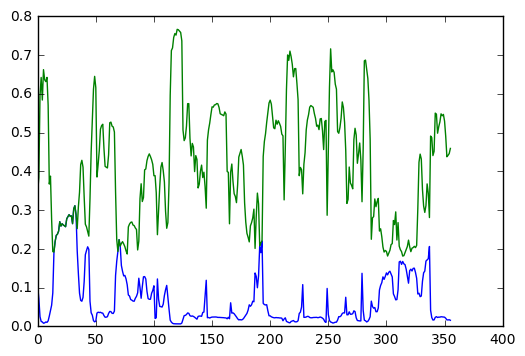

0.41684581227
0.566266490698


In [28]:
plt.plot(props[:,3])
plt.plot(props_best)
plt.show()
print props_best.mean()
print props_best.mean()+props_best.std()

In [29]:

decs=[0.5, 0.54, 0.58, 0.62, 0.66, 0.68, 0.70, 0.74]
decs=[0.66]
decs=[0.725]
for vals in decs:
    new_array=[]
    selected_data=[]
    selected_data=0*predicted_random_forest
    count=0
    for idx, val in enumerate(props_best):
        if val > vals:
            new_array.append(predicted_random_forest[idx])
            selected_data[idx]=True
            count+=1
        else:
            selected_data[idx]=False
            

    selected_pred_facies=predicted_random_forest[selected_data==True]
    #selected_true_labels=correct_facies_labels[selected_data==True]    
    #out_f1=metrics.f1_score(selected_true_labels, selected_pred_facies,average = 'micro')
    
    print("vals of decs is  %.5f " %  (vals) ) 
    print("nr of samples %d " %  (count) )     
    print("total nr of facies predicted is %d" % (len(np.unique(selected_pred_facies))))
    #print("total nr of facies present is %d" % (len(np.unique(selected_true_labels))))    
    #print("f1 is  %.5f " %  (out_f1) ) 
    #dothererun(selected_pred_facies)   
    print "-------------------------------------------------"

vals of decs is  0.72500 
nr of samples 8 
total nr of facies predicted is 1
-------------------------------------------------


In [31]:
training_data_dodgy = blind[selected_data==True] 
training_data_dodgy1 = training_data_dodgy.drop(['Formation', 'Well Name', 'Depth'], axis=1)
correct_facies_labels_train = selected_pred_facies
#----------------------------------------------------------------------------

wells = training_data["Well Name"].values      #DOES NOT CONTAIN THE BLIND
y = training_data['Facies']
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1)

count=0

lpgo = LeavePGroupsOut(n_groups=6)
#pred_array=np.zeros(474)    #stu
pred_array=np.zeros(356)    #craw
for train, test in lpgo.split(X, y, groups=wells):
    xx0=X.iloc[train]
    yy0=y.iloc[train]
    XTRAIN = pd.concat([xx0, training_data_dodgy1], ignore_index=True)
    YTRAIN=np.concatenate((yy0.values, correct_facies_labels_train))
    
    selected_pred_facies=predicted_random_forest[selected_data==True]

    rf = RandomForestClassifier(max_depth = 15, n_estimators=2000) 
    rf.fit(XTRAIN, YTRAIN)
    
    predicted_random_forest = rf.predict(features_blind)    #prediction on blind  
    pred_array = np.vstack((predicted_random_forest, pred_array))
    count+=1
    print count
    
med_pred=np.median(pred_array,axis=0)
med_pred=med_pred.astype(int)
#out_f1=metrics.f1_score(correct_facies_labels, med_pred,average = 'micro')
#print "prediction from median, leave p out+augmentation:"
#print out_f1        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [22]:
predicted_stu=med_pred
predicted_stu

array([2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 8, 8, 8,
       8, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 8, 6,
       6, 6, 6, 6, 6, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 2, 2, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 8, 8, 8,
       8, 8, 8, 8, 7, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 8,
       8, 8,

In [32]:
predicted_craw=med_pred
predicted_craw

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 5, 6, 5, 5, 4, 4, 4, 4, 4, 4,
       7, 7, 7, 7, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6,
       8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6,
       6, 4, 4, 8, 8, 8, 4, 4, 4, 5, 5, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8, 6,
       6, 6, 6, 6, 6, 6, 6, 8, 8, 3, 3, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6,
       6, 6, 8, 8, 8, 6, 6, 8, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7,
       7, 7, 7, 7, 8, 8, 8, 6, 4, 8, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7,

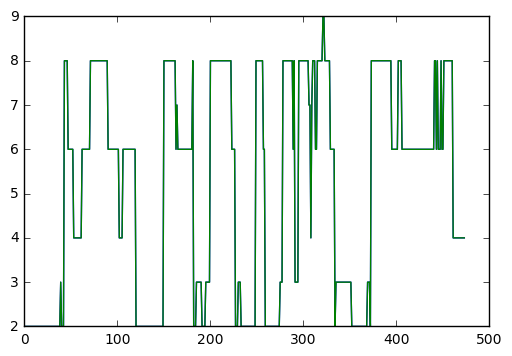

In [426]:
plt.plot(predicted_stu)
plt.show()

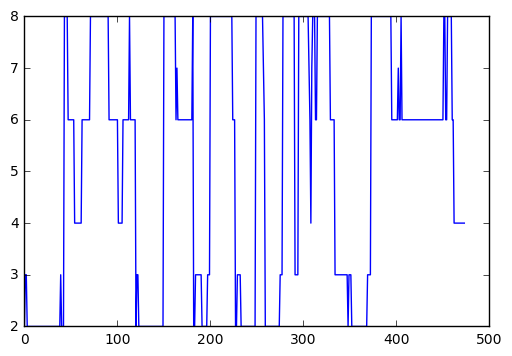

In [21]:
plt.plot(predicted_stu)
plt.show()